In [1]:
reset -sf

In [29]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path

# univariate mlp example
from numpy import array

from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout,GRU,LSTM

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.externals import joblib 
import matplotlib.pyplot as plt

In [3]:
PATH = Path("../data/")

In [4]:
scaler = joblib.load(PATH/'train_scaler_x.pkl')

/home/administrador/anaconda3/envs/deeplung/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
dfX_Train = np.load(PATH/'train_x.npy')
dfX_Val = np.load(PATH/'val_x.npy') 
dfX_Test = np.load(PATH/'test_x.npy')
dfY_Train = np.load(PATH/'train_y.npy')
dfY_Val = np.load(PATH/'val_y.npy')
dfY_Test = np.load(PATH/'test_y.npy')
print(dfX_Train.shape, dfY_Train.shape)
print(dfX_Val.shape, dfY_Val.shape)
print(dfX_Test.shape, dfY_Test.shape)
print(dfX_Train[0,:10])

(8126, 2500) (8126, 1250)
(1016, 2500) (1016, 1250)
(1016, 2500) (1016, 1250)
[1.0743 1.0802 1.1212 1.2092 1.35   1.5396 1.7664 2.0088 2.2473 2.4399]


In [6]:
history=None
freq = 125
ini = 0 #freq
dim = freq * 2
ecg = 1250

In [7]:
#Normalize Y
rng = (dfY_Train[:,ini:ini+dim].max(axis=1) - dfY_Train[:,ini:ini+dim].min(axis=1))
trainY_n = np.array([dfY_Train [:,i] - dfY_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Val[:,ini:ini+dim].max(axis=1) - dfY_Val[:,ini:ini+dim].min(axis=1))
valY_n = np.array([dfY_Val [:,i] - dfY_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Test[:,ini:ini+dim].max(axis=1) - dfY_Test[:,ini:ini+dim].min(axis=1))
testY_n = np.array([dfY_Test [:,i] - dfY_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

trainY_n = trainY_n.T
valY_n = valY_n.T
testY_n = testY_n.T 

In [8]:
#Normalize X
rng = (dfX_Train[:,ini:ini+dim].max(axis=1) - dfX_Train[:,ini:ini+dim].min(axis=1))
trainX_0_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Train[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Train[:,ecg+ini:ini+ecg+dim].min(axis=1))
trainX_1_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Val[:,ini:ini+dim].max(axis=1) - dfX_Val[:,ini:ini+dim].min(axis=1))
valX_0_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Val[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Val[:,ecg+ini:ini+ecg+dim].min(axis=1))
valX_1_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Test[:,ini:ini+dim].max(axis=1) - dfX_Test[:,ini:ini+dim].min(axis=1))
testX_0_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Test[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Test[:,ecg+ini:ini+ecg+dim].min(axis=1))
testX_1_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

trainX_0_n = trainX_0_n.T
trainX_1_n = trainX_1_n.T
valX_0_n = valX_0_n.T
valX_1_n = valX_1_n.T
testX_0_n = testX_0_n.T 
testX_1_n = testX_1_n.T

print(trainX_0_n.shape,trainX_1_n.shape)
print(valX_0_n.shape,valX_1_n.shape)
print(testX_0_n.shape,testX_1_n.shape)

(8126, 250) (8126, 250)
(1016, 250) (1016, 250)
(1016, 250) (1016, 250)


In [9]:
trainX_n = np.stack((trainX_0_n, trainX_1_n), axis=2)
valX_n = np.stack((valX_0_n,valX_1_n), axis=2)
testX_n = np.stack((testX_0_n, testX_1_n), axis=2)

print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [55]:
# define model
model = Sequential()
model.add(Conv1D(filters=512, kernel_size=32, activation='relu', input_shape=(dim, 2)))
#model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(dim, 2)))
model.add(MaxPooling1D(pool_size=5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GRU(256, dropout=0.5, recurrent_dropout=0.5))#,return_sequences=True))
#model.add(BatchNormalization())
#model.add(GRU(128, dropout=0.5, recurrent_dropout=0.5))
          

#model.add(GRU(16, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(dim))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 219, 512)          33280     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 43, 512)           0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 43, 512)           2048      
_________________________________________________________________
dropout_25 (Dropout)         (None, 43, 512)           0         
_________________________________________________________________
gru_28 (GRU)                 (None, 256)               590592    
_________________________________________________________________
dense_22 (Dense)             (None, 250)               64250     
Total params: 690,170
Trainable params: 689,146
Non-trainable params: 1,024
_________________________________________________________________


In [56]:
# fit model
model.compile(optimizer=optimizers.Adam(lr=1e-2), loss='mse')
history_prev = history
history = model.fit(trainX_n, trainY_n, validation_data=(valX_n, valY_n), batch_size=128, epochs=20, verbose=1)

Train on 8126 samples, validate on 1016 samples
Epoch 1/20
8126/8126 [==============================] - 10s 1ms/step - loss: 0.1063 - val_loss: 0.0624
Epoch 2/20
8126/8126 [==============================] - 6s 726us/step - loss: 0.0545 - val_loss: 0.0417
Epoch 3/20
8126/8126 [==============================] - 6s 728us/step - loss: 0.0437 - val_loss: 0.0315
Epoch 4/20
8126/8126 [==============================] - 6s 729us/step - loss: 0.0393 - val_loss: 0.0283
Epoch 5/20
8126/8126 [==============================] - 6s 723us/step - loss: 0.0360 - val_loss: 0.0254
Epoch 6/20
8126/8126 [==============================] - 6s 735us/step - loss: 0.0350 - val_loss: 0.0252
Epoch 7/20
8126/8126 [==============================] - 6s 727us/step - loss: 0.0341 - val_loss: 0.0246
Epoch 8/20
8126/8126 [==============================] - 6s 730us/step - loss: 0.0334 - val_loss: 0.0233
Epoch 9/20
8126/8126 [==============================] - 6s 731us/step - loss: 0.0325 - val_loss: 0.0236
Epoch 10/20
8126/

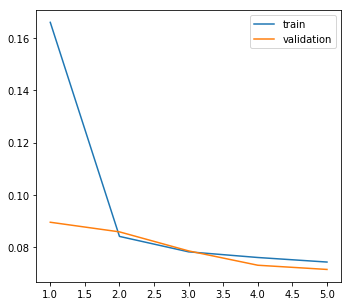

In [14]:
plt.figure(figsize=(12,5))
for i in range(2):
    if i == 0:
        if history_prev is None:
            continue
        else:
            hist = history_prev
    else:
        hist = history
        
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(loss) +1)
    ax = plt.subplot(1,2,1+i)
    ax.plot(epochs, loss, label="train")
    ax.plot(epochs, val_loss, label="validation")
    ax.set_xticks(epochs, epochs)
    ax.legend()

plt.show()

In [ ]:
# Save the weights and architecture

In [14]:
model.save_weights('conv1d_rnn_1.h5')
with open('conv1d_rnn_1.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='mse')
model.fit(scaler.transform(dfX_Train).reshape(dfX_Train.shape[0],dfX_Train.shape[1],1), 
          dfY_Train, validation_data=((scaler.transform(dfX_Val).reshape(dfX_Val.shape[0],dfX_Val.shape[1],1)
                                       , dfY_Val)), batch_size= 32, epochs=20, verbose=1)